## Imports

In [18]:
# imports
import warnings
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tabulate import tabulate

## Configuring General Settings 

In [19]:
# general settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

## Loading Data

In [20]:
# load data
ticker = "BA"
df_boeing = yf.download(ticker, start="2020-01-01", end="2023-10-01")

[*********************100%%**********************]  1 of 1 completed


## EDA & Data Cleaning

In [21]:
print("Data Shape:", df_boeing.shape)
df_boeing.head()

Data Shape: (943, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,328.549988,333.350006,327.700012,333.320007,331.348572,4544400
2020-01-03,330.630005,334.890015,330.299988,332.760010,330.791901,3875900
2020-01-06,329.299988,334.859985,327.880005,333.739990,331.766083,5355000
2020-01-07,334.260010,344.190002,330.709991,337.279999,335.285156,9898600
2020-01-08,332.399994,334.029999,329.600006,331.369995,329.410095,8239200


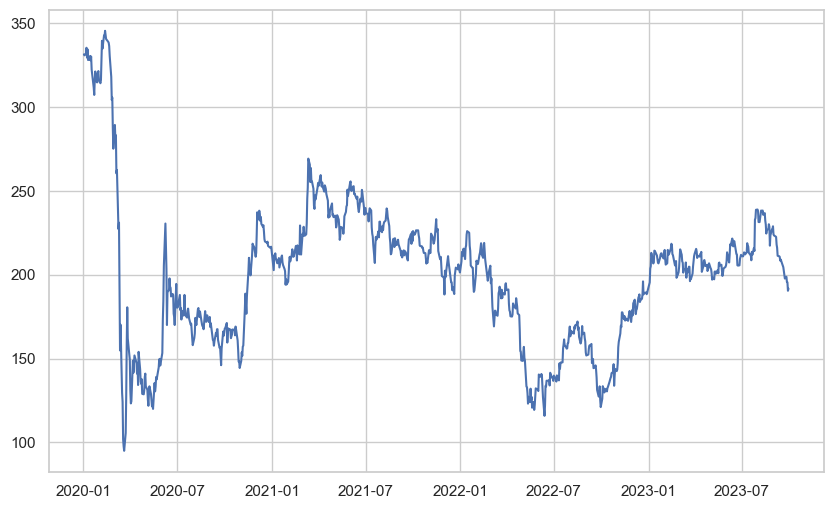

In [22]:
plt.figure(figsize=(10,6))
plt.plot(df_boeing["Adj Close"])

The daily Boeing stock price process is not stationary and it dosen't represent a well defined trend and seasonality

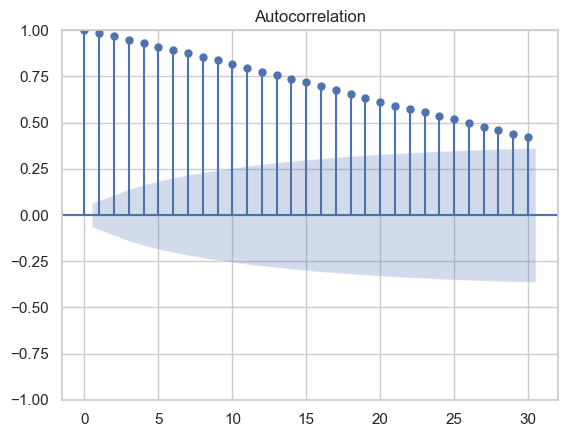

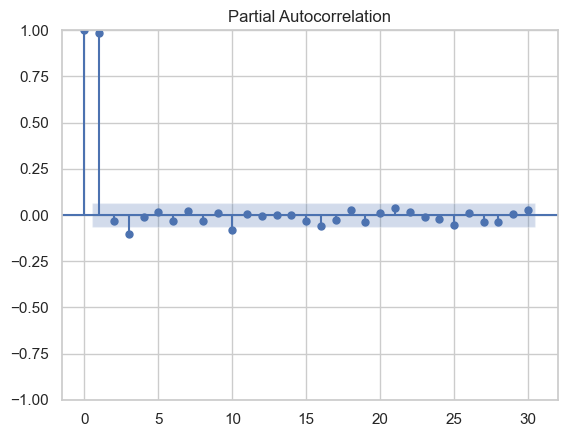

In [23]:
plot_acf(df_boeing["Adj Close"])
plot_pacf(df_boeing["Adj Close"])
plt.show()

We see that the autocorrelation function decrease progressively over lags which not allow us the fix the MA order. On the other hand the partial autocorrelation decrease dramatically from 1 lag so we can fix the AR order to 1.

In [24]:
# interpolate missing raws
df_adj_close = df_boeing["Adj Close"]
start_date = df_adj_close.index.min()
end_date = df_adj_close.index.max()
full_index = pd.date_range(start=start_date, end=end_date, freq='D')
df_adj_close = df_adj_close.reindex(full_index)
df_adj_close.interpolate(inplace=True)

## Modeling & Evaluation

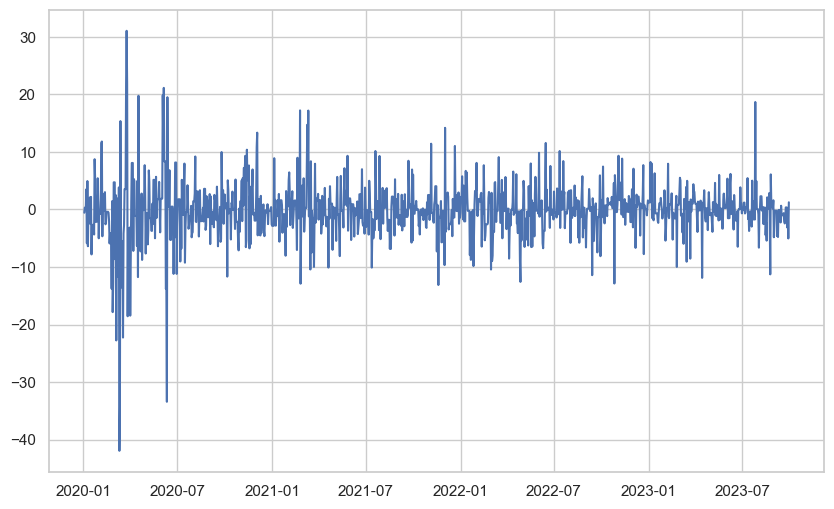

In [25]:
plt.figure(figsize=(10,6))
plt.plot(df_adj_close.diff(1).dropna())

The process trend was removed after applying an integration to order 1, so we can fix the integration order to 1.

In [26]:
# train-test split data for the ARIMA model
df_train = df_adj_close[:-300]
df_test = df_adj_close[-300:]

In [27]:
# try different MA orders
for i in range(5):
    arima_model = ARIMA(df_train, order=(1,1,i))
    arima_model_fit = arima_model.fit()
    print(f"* MA order = {i}\n{arima_model_fit.summary()}")

* MA order = 0
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1067
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3227.175
Date:                Thu, 04 Apr 2024   AIC                           6458.349
Time:                        23:55:36   BIC                           6468.293
Sample:                    01-02-2020   HQIC                          6462.117
                         - 12-03-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1526      0.012     12.918      0.000       0.129       0.176
sigma2        24.9491      0.429     58.113      0.000      24.108      25.791
Ljung-Box (L1) (Q):                  

* MA order = 1
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1067
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3221.813
Date:                Thu, 04 Apr 2024   AIC                           6449.626
Time:                        23:55:36   BIC                           6464.541
Sample:                    01-02-2020   HQIC                          6455.277
                         - 12-03-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6322      0.060     10.572      0.000       0.515       0.749
ma.L1         -0.4889      0.067     -7.329      0.000      -0.620      -0.358
sigma2        24.6982      0.436     

The overall best MA order is 1

In [28]:
# 7 steps forecast with the ARIMA model
start = df_train.shape[0]-1
ends_list = [start+30*i for i in range(df_test.shape[0]//30)]
predict_list = []
for i in ends_list:
    arima_model = ARIMA(df_adj_close.iloc[:i], order=(1,1,1))
    arima_model_fit = arima_model.fit()
    predict_list = predict_list + arima_model_fit.forecast(30).to_list()

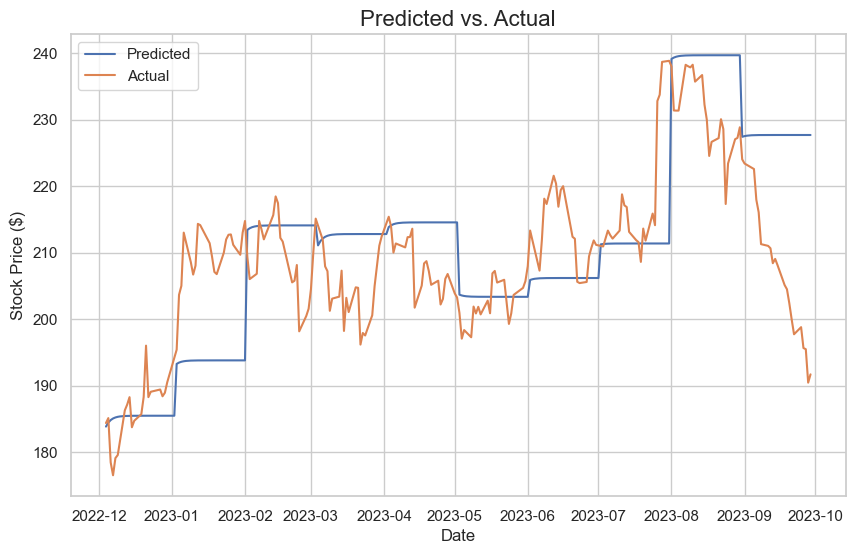

In [29]:
# plot predicted and actual values for the Prophet model
plt.figure(figsize=(10,6))
plt.plot(df_test[:len(predict_list)].index, predict_list, label="Predicted")
plt.plot(df_test[:len(predict_list)], label="Actual")
plt.title("Predicted vs. Actual", size=16)
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

In [30]:
def regression_metrics_ARMA(model, y_train, y_test, y_test_pred) :
    start_train = y_train.index[0]
    end_train = y_train.index[-1]
    y_test = y_test[:len(y_test_pred)]
    y_train_pred = model.predict(start=start_train, end=end_train)
    tab = tabulate([["Metric","Training Set","Test Set"],
                  ["r2",r2_score(y_train,y_train_pred),r2_score(y_test,y_test_pred)],
                  ["MSE",mean_squared_error(y_train,y_train_pred),mean_squared_error(y_test,y_test_pred)],
                  ["MAE",mean_absolute_error(y_train,y_train_pred),mean_absolute_error(y_test,y_test_pred)],
                  ["RMSE",mean_squared_error(y_train,y_train_pred,squared=False),mean_squared_error(y_test,y_test_pred,squared=False)]],
                headers='firstrow',numalign="left")
    return tab
print(regression_metrics_ARMA(arima_model_fit, df_train, df_test, predict_list))

Metric    Training Set    Test Set
--------  --------------  ----------
r2        0.945446        0.12569
MSE       127.578         131.305
MAE       3.43709         8.57794
RMSE      11.295          11.4588


- The r2 score shows that the ARIMA model has explained 13% the testing data variance.
- Depending on the MAE score, the model tends to make an error of about $9, and since the root mean squared error is not significantly higher than the mean absolute error, this shows us that the errors have a close values.

In [31]:
# train-test split data for the Prophet model
df_prophet = df_adj_close.reset_index()
df_prophet["index"] = pd.to_datetime(df_prophet["index"])
df_prophet.columns = ["ds","y"]
df_train_prophet = df_prophet.iloc[:-300]
df_test_prophet = df_prophet.iloc[-300:]

In [32]:
# 7 steps forecast with the Prophet model
start = df_train.shape[0]-1
ends_list = [start+30*i for i in range(df_test.shape[0]//30)]
predict_list_prophet = []
for i in ends_list:
    prophet_model = Prophet()
    prophet_model.fit(df_prophet.iloc[:i])
    future = prophet_model.make_future_dataframe(periods=30, include_history=False)
    predict_list_prophet = predict_list_prophet + prophet_model.predict(future)["yhat"].to_list()

23:55:42 - cmdstanpy - INFO - Chain [1] start processing
23:55:42 - cmdstanpy - INFO - Chain [1] done processing
23:55:43 - cmdstanpy - INFO - Chain [1] start processing
23:55:44 - cmdstanpy - INFO - Chain [1] done processing
23:55:44 - cmdstanpy - INFO - Chain [1] start processing
23:55:45 - cmdstanpy - INFO - Chain [1] done processing
23:55:46 - cmdstanpy - INFO - Chain [1] start processing
23:55:46 - cmdstanpy - INFO - Chain [1] done processing
23:55:47 - cmdstanpy - INFO - Chain [1] start processing
23:55:47 - cmdstanpy - INFO - Chain [1] done processing
23:55:48 - cmdstanpy - INFO - Chain [1] start processing
23:55:49 - cmdstanpy - INFO - Chain [1] done processing
23:55:49 - cmdstanpy - INFO - Chain [1] start processing
23:55:50 - cmdstanpy - INFO - Chain [1] done processing
23:55:51 - cmdstanpy - INFO - Chain [1] start processing
23:55:51 - cmdstanpy - INFO - Chain [1] done processing
23:55:52 - cmdstanpy - INFO - Chain [1] start processing
23:55:53 - cmdstanpy - INFO - Chain [1]

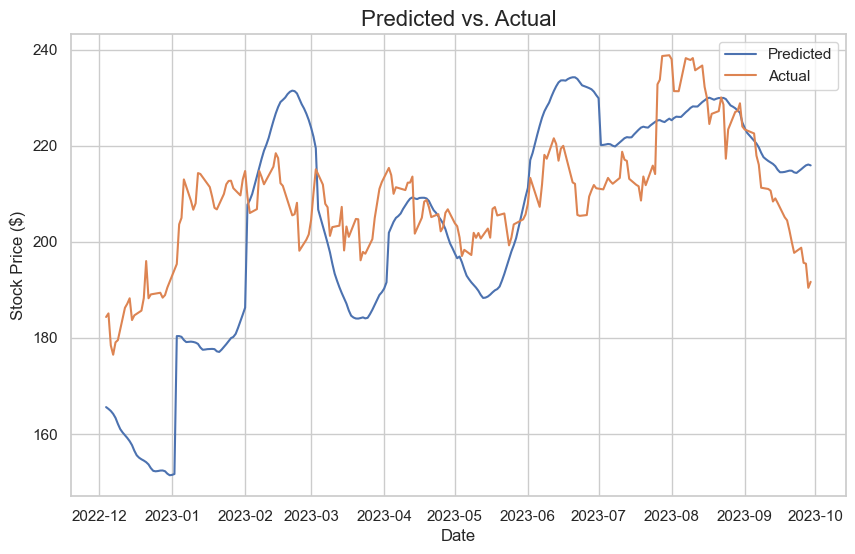

In [33]:
# plot predicted and actual values for the Prophet model
plt.figure(figsize=(10,6))
plt.plot(df_test_prophet["ds"][:len(predict_list_prophet)], predict_list_prophet, label="Predicted")
plt.plot(df_test_prophet["ds"][:len(predict_list_prophet)], df_test_prophet["y"][:len(predict_list_prophet)], label="Actual")
plt.title("Predicted vs. Actual", size=16)
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

In [34]:
y_train = df_train_prophet["y"]
y_test = df_test_prophet["y"][:len(predict_list_prophet)]
y_train_pred = prophet_model.predict(df_train_prophet)["yhat"]
tab = tabulate([["Metric", "Training Set","Test Set"],
                  ["r2", r2_score(y_train, y_train_pred), r2_score(y_test, predict_list_prophet)],
                  ["MSE", mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, predict_list_prophet)],
                  ["MAE", mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, predict_list_prophet)],
                  ["RMSE", mean_squared_error(y_train, y_train_pred, squared=False),
                   mean_squared_error(y_test, predict_list_prophet, squared=False)]],
                headers='firstrow', numalign="left")
   
print(tab)

Metric    Training Set    Test Set
--------  --------------  ----------
r2        0.856047        -1.12768
MSE       336.643         319.537
MAE       13.3061         14.3278
RMSE      18.3478         17.8756


- The r2 score shows that the Prophet model has failed to explain the data variance.
- Depending on the MAE score, the model tends to make an error of about $14, and since the root mean squared error is not significantly higher than the mean absolute error, this shows us that the errors have a close values.

Depnding on all the used scores, The ARIMA model has a better performance. 